In [67]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [68]:
numpy.random.seed(7)

In [69]:
dataframe = pandas.read_csv('Bitcoin.csv', usecols=[1], engine='python', skipfooter=3)
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset.shape

(1632, 1)

In [70]:
dataframe.head()

,Price
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [71]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
dataset.shape

(1632, 1)

In [72]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
print(train.shape)
test.shape

(1093, 539)
(1093, 1)


(539, 1)

In [73]:

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    c = 0
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        #print(a)
        c+=1
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    #print(c)
    return numpy.array(dataX), numpy.array(dataY)

In [74]:
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1091, 1)
(1091,)
(537, 1)
(537,)


In [75]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1091, 1, 1)
(1091,)
(537, 1, 1)
(537,)


In [76]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
5s - loss: 1.2005e-04 - acc: 0.2704
Epoch 2/100
4s - loss: 9.7405e-06 - acc: 0.2704
Epoch 3/100
4s - loss: 2.6005e-06 - acc: 0.2704
Epoch 4/100
5s - loss: 2.8607e-06 - acc: 0.2704
Epoch 5/100
7s - loss: 3.2500e-06 - acc: 0.2704
Epoch 6/100
7s - loss: 2.8589e-06 - acc: 0.2704
Epoch 7/100
6s - loss: 3.1626e-06 - acc: 0.2704
Epoch 8/100
6s - loss: 3.1549e-06 - acc: 0.2704
Epoch 9/100
7s - loss: 3.1431e-06 - acc: 0.2704
Epoch 10/100
3s - loss: 3.2991e-06 - acc: 0.2704
Epoch 11/100
4s - loss: 3.0064e-06 - acc: 0.2704
Epoch 12/100
7s - loss: 3.1147e-06 - acc: 0.2704
Epoch 13/100
5s - loss: 3.0498e-06 - acc: 0.2704
Epoch 14/100
4s - loss: 2.8922e-06 - acc: 0.2704
Epoch 15/100
4s - loss: 2.8195e-06 - acc: 0.2704
Epoch 16/100
4s - loss: 3.5038e-06 - acc: 0.2704
Epoch 17/100
4s - loss: 3.0526e-06 - acc: 0.2704
Epoch 18/100
6s - loss: 2.8528e-06 - acc: 0.2704
Epoch 19/100
5s - loss: 2.8627e-06 - acc: 0.2704
Epoch 20/100
5s - loss: 3.0466e-06 - acc: 0.2704
Epoch 21/100
5s - loss: 2.982

In [77]:
trainPredict = model.predict(trainX)
#print(trainPredict)
testPredict = model.predict(testX)
#print([trainY])
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 22.70 RMSE
Test Score: 723.21 RMSE


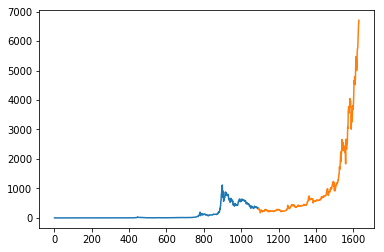

In [78]:
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
#plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [79]:
#save keras model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [81]:
from keras.models import Sequential
from keras.layers import Dense
from keras.models import model_from_json
import numpy
import os

In [82]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [84]:

# evaluate loaded model on test data
loaded_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
testPredict = model.predict(testX)
testPredict = scaler.inverse_transform(testPredict)
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 723.21 RMSE
